In [ ]:
# default_exp he

# Homomorphic trees

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
from cryptotree.core import SigmoidClassificationTree

In [ ]:
from seal import *
import numpy as np

In [ ]:
from typing import List

In [ ]:
# export
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
import torch
from numpy.polynomial.chebyshev import Chebyshev

def print_vector(vec, print_size=4, prec=3):
    slot_count = len(vec)
    print()
    if slot_count <= 2*print_size:
        print("    [", end="")
        for i in range(slot_count):
            print(" " + (f"%.{prec}f" % vec[i]) + ("," if (i != slot_count - 1) else " ]\n"), end="")
    else:
        print("    [", end="")
        for i in range(print_size):
            print(" " + (f"%.{prec}f" % vec[i]) + ",", end="")
        if len(vec) > 2*print_size:
            print(" ...,", end="")
        for i in range(slot_count - print_size, slot_count):
            print(" " + (f"%.{prec}f" % vec[i]) + ("," if (i != slot_count - 1) else " ]\n"), end="")
    print()
    
def ptx_value(ptx, i=0):
    result = DoubleVector()
    encoder.decode(ptx,result)
    value = result[i]
    return value
    
def ctx_value(ctx, i=0):
    ptx = Plaintext()
    decryptor.decrypt(ctx, ptx)
    value = ptx_value(ptx,i)
    return value
    
def print_ctx(ctx):
    ptx = Plaintext()
    decryptor.decrypt(ctx, ptx)
    result = DoubleVector()
    encoder.decode(ptx,result)
    print_vector(result, 3, 7)
    
def print_ptx(ptx):
    result = DoubleVector()
    encoder.decode(ptx,result)
    print_vector(result, 3, 7)
    
def print_range_ctx(ctx, end=0, begin=0):
    r = range(begin,end)
    for i in r:
        print(ctx_value(ctx, i))
        
def print_range_ptx(ptx, end=0, begin=0):
    r = range(begin,end)
    for i in r:
        print(ptx_value(ptx, i))

def chebyshev_approximation(f, dilatation_factor=50, polynomial_degree=25, bound=1, convertToTensor=True):
    if convertToTensor:
        f_a = lambda x: f(torch.tensor(x*dilatation_factor))
    else:
        f_a = lambda x: f(x*dilatation_factor)
        
    domain = [-bound,bound]

    p = Chebyshev.interpolate(f_a,deg=polynomial_degree,domain=domain)
    return p, f_a

def polynomial_approximation_coefficients(f, dilatation_factor=50, polynomial_degree=25, 
                                          bound=1, convertToTensor=True):
    p,_ = chebyshev_approximation(f, dilatation_factor, polynomial_degree, bound, convertToTensor)
    
    return Polynomial.cast(p).coef

def plot_graph_function_approximation(f, dilatation_factor=50, polynomial_degree=25, bound=1, convertToTensor=True):
    
    p, f_a = chebyshev_approximation(f, dilatation_factor, polynomial_degree, bound, convertToTensor)
    
    domain = [-bound,bound]
    x = np.linspace(*domain,100)
    y = f_a(x)
    pred = p(x)

    fig, ax = plt.subplots()

    # plot the function
    ax.plot(x,y, 'g', label="Sigmoid")
    ax.plot(x,pred,"b-", label=f"Polynomial approximation")
    ax.legend()

    # show the plot
    fig.suptitle(f"Tchebytchev polynomials with expansion a={dilatation_factor} and degree n={polynomial_degree}")
    fig.show()
    
    return fig,ax

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fda77d06828>)

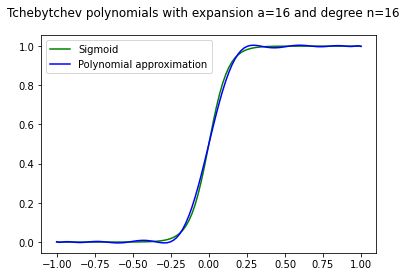

In [ ]:
dilatation_factor = 16
degree = 16

p,_ = chebyshev_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
coeffs = polynomial_approximation_coefficients(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)
plot_graph_function_approximation(torch.sigmoid, dilatation_factor=dilatation_factor,
                                              polynomial_degree=degree)

In [ ]:
np.log2(coeffs.max())

9.728525111322655

In [ ]:
PRECISION_BITS = 50
UPPER_BITS = 10

polynomial_multiplications = int(np.ceil(np.log2(degree))) + 1
n_polynomials = 2
matrix_multiplications = 4

depth = matrix_multiplications + polynomial_multiplications * n_polynomials

poly_modulus_degree = 32768

moduli = [PRECISION_BITS + UPPER_BITS] + (depth) * [PRECISION_BITS] + [PRECISION_BITS + UPPER_BITS]
print(moduli)
print(sum(moduli))

[60, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 60]
820


In [ ]:
parms = EncryptionParameters(scheme_type.CKKS)
parms.set_poly_modulus_degree(poly_modulus_degree)
parms.set_coeff_modulus(CoeffModulus.Create(
    poly_modulus_degree, moduli))

scale = pow(2.0, PRECISION_BITS)
context = SEALContext.Create(parms)

# Key creations
keygen = KeyGenerator(context)
public_key = keygen.public_key()
secret_key = keygen.secret_key()
relin_keys = keygen.relin_keys()
galois_keys = keygen.galois_keys()

encryptor = Encryptor(context, public_key)
evaluator = Evaluator(context)
decryptor = Decryptor(context, secret_key)
encoder = CKKSEncoder(context)

## Polynomial evaluation

In [ ]:
# export
def coeffs_to_plaintext(coeffs: List[float], encoder: CKKSEncoder, scale: float) -> List[Plaintext]:
    """Computes the plaintext encodings of coefficients"""
    plain_coeffs = []

    for coef in coeffs:
        plain_coeff = Plaintext()
        encoder.encode(coef, scale, plain_coeff)
        plain_coeffs.append(plain_coeff)
        
    return plain_coeffs

def compute_all_powers(ctx : Ciphertext, degree: int, evaluator: Evaluator, 
                       relin_keys: RelinKeys, verbose=False):

    powers = [None] * (degree+1)
    levels = np.zeros(degree+1)

    powers[1] = ctx
    levels[0] = levels[1] = 0
    
    
    for i in range(2,degree+1):
            
        minlevel = i
        cand = -1
        
        for j in range(1, i // 2 +1):
            k = i - j
            newlevel = max(levels[k],levels[j]) + 1
            if newlevel < minlevel:
                cand = j
                minlevel = newlevel
                
        if verbose:
            print(f"i = {i}, i-cand = {i-cand}")
            print(f"level for cand : {levels[cand]}, level for {i-cand} : {levels[i-cand]}")
            print(f"minlevel = {minlevel}")
            print(f"cand = {cand}")
        
        levels[i] = minlevel
        
        temp = Ciphertext()
        
        power_cand = powers[cand]
        evaluator.mod_switch_to(power_cand, powers[i-cand].parms_id(),temp)
        evaluator.multiply(temp, powers[i-cand], temp)
        evaluator.relinearize_inplace(temp, relin_keys)
        evaluator.rescale_to_next_inplace(temp)
        
        powers[i] = temp
        
    return powers

In [ ]:
# export
def multiply_and_add_coeffs(powers: List[Ciphertext], plain_coeffs: List[Plaintext],
                            coeffs: List[float],
                            evaluator: Evaluator, encryptor: Encryptor,
                            tol=1e-3, verbose=False) -> Ciphertext:
    assert len(powers) == len(plain_coeffs), f"Mismatch between length between powers {len(powers)} and coeffs {len(coeffs)}"
    output = Ciphertext()
    
    x = ctx_value(powers[1])
    
    expected_output = coeffs[0]
    encryptor.encrypt(plain_coeffs[0],output)
    
    temp = Ciphertext()
    
    for i in range(1, len(plain_coeffs)):
        # We first check if the coefficient is not too small otherwise we skip it
        coef = coeffs[i]
        if np.abs(coef) < tol:
            continue
            
        plain_coeff = plain_coeffs[i]
        power = powers[i]
        
        evaluator.mod_switch_to_inplace(plain_coeff, power.parms_id())
        
        evaluator.multiply_plain(power, plain_coeff, temp)
        evaluator.rescale_to_next_inplace(temp)
        
        evaluator.mod_switch_to_inplace(output, temp.parms_id())
        output.scale(pow(2.0,PRECISION_BITS))
        temp.scale(pow(2.0,PRECISION_BITS))
        evaluator.add_inplace(output, temp)
        
        expected_output = coef * (x ** i)
        if verbose:
            print(f"{i} Expected output : {expected_output}, output : {ctx_value(temp)}")
    return output

In [ ]:
def polyeval_tree(ctx : Ciphertext, coeffs: List[float], 
                  evaluator: Evaluator, encoder : Encryptor, encryptor : Encryptor,
                  relin_keys: RelinKeys,
                  scale: float,
                  verbose=False):
    
    degree = len(coeffs) - 1
    plain_coeffs = coeffs_to_plaintext(coeffs, encoder, scale)
    powers = compute_all_powers(ctx, degree, evaluator, relin_keys)
    output = multiply_and_add_coeffs(powers, plain_coeffs, coeffs, evaluator, encryptor, verbose=verbose)
    
    return output

In [ ]:
def float_to_ctx(x, encoder: CKKSEncoder, encryptor: Encryptor):
    ptx = Plaintext()
    encoder.encode(x, scale, ptx)

    ctx = Ciphertext()
    encryptor.encrypt(ptx, ctx)
    
    return ctx

In [ ]:
x = 0.2

ctx = float_to_ctx(x, encoder, encryptor)
output = polyeval_tree(ctx, coeffs, evaluator, encoder, encryptor, relin_keys, scale, verbose=False)

print_ctx(output)
print(p(x))
print(torch.sigmoid(torch.tensor(x * dilatation_factor)))


    [ 0.9671459, 0.9671459, 0.9671459, ..., 0.9671459, 0.9671459, 0.9671459 ]

0.9671459059436528
tensor(0.9608)


## Matrix multiplications

In [ ]:
# export
def vrep(x, n):
    k = n // len(x)
    rest = n % len(x)
    output = x * k + x[:rest]
    return output

In [ ]:
# export
import torch.nn as nn

def apply_comparator(ctx: Ciphertext, comparator: nn.Linear, 
                     encoder: CKKSEncoder, evaluator: Evaluator) -> Ciphertext:
    n = encoder.slot_count()
    
    output = Ciphertext()
    row_ptx = Plaintext()
    
    # We repeat the bias vector
    bias_ptx = Plaintext()
    bias = list(comparator.bias.data.numpy())
    bias = repeat_vector(bias,n)
    bias = DoubleVector(bias)
    encoder.encode(bias, scale, bias_ptx)
    
    matrix = comparator.weight.data.numpy()

    for i in range(matrix.shape[0]):
        row = matrix[i]
        source = row.argmax()
        rotation = source - i

        # We encode the current row
        row = list(row)
        row = repeat_vector(row, n)
        row = DoubleVector(row)
        encoder.encode(row,scale, row_ptx)

        temp = Ciphertext()
        evaluator.multiply_plain(ctx, row_ptx, temp)
        evaluator.rescale_to_next_inplace(temp)
        
        # If we must rotate
        if np.abs(rotation) > 0:
            evaluator.rotate_vector_inplace(temp, rotation, galois_keys)

        if i == 0:
            output = temp
        else:
            evaluator.add_inplace(output,temp)

    evaluator.mod_switch_to_inplace(bias_ptx, output.parms_id())
    output.scale(scale)
    evaluator.add_plain_inplace(output, bias_ptx)
    
    return output

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

iris = load_iris()
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
X_train = scaler.fit_transform(X_train)

estimator = DecisionTreeClassifier(max_depth=4, random_state=0)
estimator.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
tree = SigmoidClassificationTree(estimator, dilatation_factor=dilatation_factor, polynomial_degree=degree)

In [ ]:
n = encoder.slot_count()
i = 1

x = X_train[i]
with torch.no_grad():
    x = tree.comparator(torch.tensor(x).float()) - tree.comparator.bias.data
    
x = list(x.numpy())
# We add a 0 at the end for future matrix multiplication
x.append(0)
x = vrep(x, encoder.slot_count())
x = DoubleVector(x)
ctx = float_to_ctx(x, encoder, encryptor)

In [ ]:
bias = list(tree.comparator.bias.data.numpy())
bias.append(0)
bias = vrep(bias, n)
bias = DoubleVector(bias)
bias_ptx = Plaintext()
encoder.encode(bias, scale, bias_ptx)

In [ ]:
output = Ciphertext()
evaluator.add_plain(ctx, bias_ptx, output)

In [ ]:
x = X_train[i]
with torch.no_grad():
    expected_output = tree.comparator(torch.tensor(x).float())

def print_comparison(expected_output: torch.tensor, output: Ciphertext):
    for i, value in enumerate(expected_output.view(-1,1)):
        print(f"Expected value : {value.item()}, real value : {ctx_value(output,i)}")
        
print_comparison(expected_output,output)

Expected value : 0.1666666865348816, real value : 0.1666666865358215
Expected value : -0.16379308700561523, real value : -0.163793087001821
Expected value : -0.1875000298023224, real value : -0.18750002980175676
Expected value : -0.2083333134651184, real value : -0.20833331346575368
Expected value : -0.2291666567325592, real value : -0.22916665673150402
Expected value : -0.1875000298023224, real value : -0.18750002980873973


In [ ]:
activation = polyeval_tree(output, coeffs, evaluator, encoder, encryptor, relin_keys, scale)
expected_activation = tree.activation(expected_output)
print_comparison(expected_activation, activation)

Expected value : 0.9350308775901794, real value : 0.9272096605557861
Expected value : 0.06781869381666183, real value : 0.07703664398648355
Expected value : 0.047425851225852966, real value : 0.04585589187355596
Expected value : 0.03444520756602287, real value : 0.02544153724376414
Expected value : 0.02492443099617958, real value : 0.01101220513236692
Expected value : 0.047425851225852966, real value : 0.045855898177134036


In [ ]:
# export
def extract_diagonals(matrix: np.ndarray, encoder: CKKSEncoder) -> List[Plaintext]:
    """Extracts the diagonals of the matrix"""
    assert matrix.shape[0] == matrix.shape[1], "Non square matrix"
    dim = matrix.shape[0]
    
    diagonals = []
    
    for i in range(dim):
        diagonal = []
        for j in range(dim):
            diagonal.append(matrix[j][(j+i) % dim])
        diagonal_ptx = Plaintext()
        encoder.encode(DoubleVector(diagonal), scale, diagonal_ptx)
        diagonals.append(diagonal_ptx)
    return diagonals

In [ ]:
# export
def matrix_multiply_diagonals(diagonals: List[Plaintext], ctx: Ciphertext, 
                              evaluator: Evaluator, galois_keys: GaloisKeys):
    output = Ciphertext()
    
    for i in range(len(diagonals)):
        
        temp = Ciphertext()
        diagonal = diagonals[i]
        
        evaluator.rotate_vector(ctx, i, galois_keys, temp)
            
        evaluator.mod_switch_to_inplace(diagonal, temp.parms_id())
        evaluator.multiply_plain_inplace(temp, diagonal)
        evaluator.rescale_to_next_inplace(temp)
        
        if i == 0:
            output = temp
        else:
            evaluator.add_inplace(output, temp)

    return output

def add_bias_ptx(bias: np.ndarray, ctx: Ciphertext, evaluator: Evaluator):
    bias = DoubleVector(list(bias))
    bias_ptx = Plaintext()
    encoder.encode(bias, scale, bias_ptx)
    
    evaluator.mod_switch_to_inplace(bias_ptx, ctx.parms_id())
    ctx.scale(scale)
    
    output = Ciphertext()
    evaluator.add_plain(ctx, bias_ptx, output)
    return output

class LinearCtx():
    def __init__(self, matrix, bias):
        self.diagonals = extract_diagonals(matrix)
        self.bias = bias
        
    def __call__(self, ctx):
        pass

In [ ]:
# export
def pad_along_axis(array: np.ndarray, target_length, axis=0):

    pad_size = target_length - array.shape[axis]
    axis_nb = len(array.shape)

    if pad_size <= 0:
        return array

    npad = [(0, 0) for x in range(axis_nb)]
    npad[axis] = (0, pad_size)

    b = np.pad(array, pad_width=npad, mode='constant', constant_values=0)

    return b

In [ ]:
matrix = tree.matcher.weight.data.numpy()
matrix = pad_along_axis(matrix, matrix.shape[0],axis=1)

diagonals = extract_diagonals(matrix, encoder)

z1 = matrix_multiply_diagonals(diagonals, activation, evaluator, galois_keys)

In [ ]:
bias = tree.matcher.bias.data.numpy()
bias = DoubleVector(list(bias))

bias_ptx = Plaintext()
encoder.encode(bias, scale, bias_ptx)
evaluator.mod_switch_to_inplace(bias_ptx, z1.parms_id())
z1.scale(scale)

evaluator.add_plain_inplace(z1, bias_ptx)

expected_z1 = tree.matcher(expected_activation)

print_comparison(expected_z1, z1)

Expected value : -0.0725051537156105, real value : -0.07120161292347407
Expected value : 0.0532977357506752, real value : 0.05071952026293394
Expected value : -0.10330118238925934, real value : -0.10490210073336108
Expected value : -0.2584860920906067, real value : -0.26308824541776676
Expected value : -0.09491677582263947, real value : -0.09210363131273988
Expected value : -0.24577482044696808, real value : -0.24348498937802732
Expected value : -0.2453709840774536, real value : -0.247456901664991


In [ ]:
activation1 = polyeval_tree(z1, coeffs, evaluator, encoder, encryptor, relin_keys, scale)

In [ ]:
expected_activation1 = tree.activation(expected_z1)

In [ ]:
print_comparison(expected_activation1, activation1)

Expected value : 0.2386523187160492, real value : 0.2807450308209591
Expected value : 0.7011465430259705, real value : 0.6594859497905865
Expected value : 0.160728320479393, real value : 0.19246816721903187
Expected value : 0.01573856547474861, real value : -0.0016417981478358823
Expected value : 0.1796576827764511, real value : 0.22431586073482254
Expected value : 0.01921999268233776, real value : 0.004189904013338408
Expected value : 0.019342172890901566, real value : 0.0026999867928260146


In [ ]:
decisions = tree.head.weight.data.numpy()

decisions_ptx = []

for i in range(decisions.shape[0]):
    
    decision_ptx = Plaintext()
    decision = list(decisions[i])
    decision = DoubleVector(decision)
    
    encoder.encode(decision, scale, decision_ptx)
    decisions_ptx.append(decision_ptx)

In [ ]:
for decision_ptx in decisions_ptx:
    print_ptx(decision_ptx)


    [ -0.0000000, -0.9024390, -0.9024390, ..., 0.0000000, 0.0000000, -0.0000000 ]


    [ -0.8292683, -0.0487805, -0.8292683, ..., 0.0000000, 0.0000000, -0.0000000 ]


    [ -1.0000000, -1.0000000, -0.9268293, ..., 0.0000000, 0.0000000, -0.0000000 ]



In [ ]:
K = tree.head.weight.data.shape[1]
status_quo = tree.head.bias.data.numpy()
status_quo = list(status_quo)

status_quo_ptx = []
for i in range(len(status_quo)):
    ptx = Plaintext()
    
    bias = status_quo[i]
    bias = bias / K
    bias = [bias] * K
    bias = DoubleVector(bias)
    encoder.encode(bias, scale, ptx)
    status_quo_ptx.append(ptx)

In [ ]:
ctx = activation1

In [ ]:
#def apply_decisions(decisions_ptx: List[Plaintext], status_quo_ptx: Plaintext,
#                    ctx: Ciphertext, evaluator: Evaluator):

outputs = []

for decision_ptx, bias in zip(decisions_ptx, status_quo_ptx):
    evaluator.mod_switch_to_inplace(decision_ptx, ctx.parms_id())
    
    output = Ciphertext()
    evaluator.multiply_plain(ctx, decision_ptx, output)
    evaluator.rescale_to_next_inplace(output)
    
    evaluator.mod_switch_to_inplace(bias, output.parms_id())
    output.scale(scale)
    evaluator.add_plain_inplace(output, bias)
    outputs.append(output)

In [ ]:
for output in outputs:
    ptx = Plaintext()
    decryptor.decrypt(output, ptx)
    
    values = DoubleVector()
    encoder.decode(ptx, values)
    
    output = sum(list(values))
    print(output)

-0.07356510404497378
0.21436957037076293
-0.3294618711661358


In [ ]:
tree.head(expected_activation1)

tensor([-0.0865,  0.2707, -0.2931], grad_fn=<AddBackward0>)

In [ ]:
print_range_ctx(output,10)

TypeError: decrypt(): incompatible function arguments. The following argument types are supported:
    1. (self: seal.Decryptor, arg0: seal.Ciphertext, arg1: seal.Plaintext) -> None

Invoked with: <seal.Decryptor object at 0x7fda75c6c848>, -0.3294618711661358, <seal.Plaintext object at 0x7fd9453f1650>

In [ ]:
%debug

> <ipython-input-40-adbb9dd13af9>(10)<module>()
      8     decision_ptx = decisions_ptx[k]
      9     temp = Ciphertext()
---> 10     evaluator.multiply_plain(ctx, decision_ptx, temp)
     11     evaluator.mod_switch_to_next_inplace(temp)
     12 

ipdb> k
0
ipdb> exit()


In [ ]:
temp = Ciphertext()
evaluator.rotate_vector(activation, 1, galois_keys, temp)
evaluator.mod_switch_to_inplace(diagonal, activation.parms_id())
evaluator.multiply_plain(activation, diagonal, temp)

In [ ]:
temp.parms_id()

[1895212817619435648,
 503439688004990125,
 5446158636874656155,
 11479346467035430585]

In [ ]:
activation.parms_id()

[1895212817619435648,
 503439688004990125,
 5446158636874656155,
 11479346467035430585]

In [ ]:
activation.scale()

3.602879701896397e+16

In [ ]:
activation.parms_id()

[1895212817619435648,
 503439688004990125,
 5446158636874656155,
 11479346467035430585]

In [ ]:
diagonal.parms_id()

[16599391804227546351,
 13956431524126816040,
 9701170472836562648,
 13482875267000799938]

In [ ]:
z1 = matrix_multiply_diagonals(diagonals, activation, evaluator, galois_keys)

ValueError: encrypted_ntt and plain_ntt parameter mismatch

In [ ]:
temp = Ciphertext()
evaluator.rotate_vector(ctx, -n, galois_keys,temp)


In [ ]:
evaluator.add_inplace(temp,ctx)

In [ ]:
n = encoder.slot_count()

In [ ]:
k = matrix.shape[0] - 1

In [ ]:
rest = n % k

In [ ]:
mask_rest = DoubleVector(list(np.ones(rest)))

In [ ]:
mask_ptx = Plaintext()
mask_encoding = encoder.encode(mask_rest, scale, mask_ptx)


In [ ]:
output = Ciphertext()
for i in range(1,n // k):
    shift = i * k
    temp = Ciphertext()
    evaluator.rotate_vector(ctx, -shift, galois_keys,temp)
    if i == 1:
        output = temp
    else:
        evaluator.add_inplace(output,temp)

KeyboardInterrupt: 

In [ ]:
output

[1, 2, 3, 1, 2, 3, 1, 2, 3, 1]

In [ ]:
n // k

2730

In [ ]:
print_range_ctx(mask_ctx, 10)

1.0000000000000169
1.0000000000001146
0.9999999999997757
1.0000000000000315
-2.9901590148285316e-14
2.7497741743318166e-13
1.3677828038735525e-13
3.2765055694117487e-13
1.0548223817695017e-13
1.7979820874300784e-13


In [ ]:
for i in range(6):
    print(ctx_value(temp,i))

1.0000000000659965
1.9999999999704239
2.9999999999900995
1.0000000000002531
2.0000000000889564
3.0000000000255054


In [ ]:
evaluator.multiply_plain(ctx, row_ptx, temp)
evaluator.rescale_to_next_inplace(temp)

In [ ]:
ctx_value(temp, 3)

0.5833332413784554

Coucou


In [ ]:
print_ctx(temp)


    [ 0.5833885, -0.0000060, 0.0000040, ..., 0.0000126, 0.0000000, 0.0000008 ]



In [ ]:
apply_comparator(ctx)

In [ ]:
i = 0

In [ ]:
print(i)
print(ctx_value(output,i))
i += 1

6
4.759257745885246e-07


In [ ]:
tree.comparator(torch.tensor(x))

tensor([ 0.2917, -0.1293, -0.0625, -0.0417, -0.1042, -0.0625],
       grad_fn=<AddBackward0>)

In [ ]:
x = 0.5
ctx = float_to_ctx(x)

powers = compute_all_powers(ctx, degree, evaluator, relin_keys)

for i in range(1,degree+1):
    print(f"{x}**{i}")
    print_ctx(powers[i])

0.5**1

    [ 0.4999978, 0.5000039, 0.5000147, ..., 0.4999935, 0.4999968, 0.5000006 ]

0.5**2

    [ 0.2499960, 0.2500039, 0.2500036, ..., 0.2499864, 0.2499931, 0.2500029 ]

0.5**3

    [ 0.1249970, 0.1250122, 0.1250121, ..., 0.1249804, 0.1249850, 0.1250007 ]

0.5**4

    [ 0.0624928, 0.0624999, 0.0624953, ..., 0.0624884, 0.0624819, 0.0624987 ]

0.5**5

    [ 0.0312464, 0.0312442, 0.0312510, ..., 0.0312469, 0.0312411, 0.0312508 ]

0.5**6

    [ 0.0156271, 0.0156262, 0.0156236, ..., 0.0156380, 0.0156255, 0.0156251 ]

0.5**7

    [ 0.0078085, 0.0078170, 0.0078146, ..., 0.0077920, 0.0078063, 0.0078179 ]

0.5**8

    [ 0.0039047, 0.0038920, 0.0039007, ..., 0.0038930, 0.0039145, 0.0039048 ]

0.5**9

    [ 0.0019534, 0.0019474, 0.0019529, ..., 0.0019569, 0.0019699, 0.0019517 ]

0.5**10

    [ 0.0009808, 0.0009777, 0.0009712, ..., 0.0009695, 0.0009703, 0.0009707 ]

0.5**11

    [ 0.0004918, 0.0004838, 0.0004840, ..., 0.0004875, 0.0004736, 0.0004937 ]

0.5**12

    [ 0.0002416, 0.0002367, 0.00

In [ ]:
??coeffs_to_plaintext

In [ ]:
output = multiply_and_add_coeffs(evaluator, encryptor, powers, plain_coeffs, coefs, PRECISION_BITS)

1 Expected output : 1.7372920174733142, output : 1.7373085329300606
3 Expected output : -3.9672168853008234, output : -3.9674249848818017
5 Expected output : 5.596768084193369, output : 5.597435644918786
7 Expected output : -4.452037630953475, output : -4.452716435287793
9 Expected output : 2.0531454012340267, output : 2.0535564731373697
11 Expected output : -0.5446121046404848, output : -0.5446871509542115
13 Expected output : 0.07705230310407982, output : 0.07709149596439588
15 Expected output : -0.004502323096786874, output : -0.0045011522573293085


In [ ]:
print_ctx(output)


    [ 0.9960624, 0.9960711, 0.9962032, ..., 0.9958951, 0.9960536, 0.9960583 ]



In [ ]:
output = DoubleVector()
encoder.decode(plain_coeffs[21], output)
print_vector(output)


    [ 218730255.213, 218730255.213, 218730255.213, 218730255.213, ..., 218730255.213, 218730255.213, 218730255.213, 218730255.213 ]



In [ ]:
evaluator.square_inplace(ctx)


In [ ]:
result = DoubleVector()
encoder.decode(ptx,result)
print_vector(result, 3, 7)


    [ 0.5000000, 0.5000000, 0.5000000, ..., 0.5000000, 0.5000000, 0.5000000 ]



In [ ]:
ctx = 